In [1]:
'''
Model:
    3 Layers GAT + 2 Layer FC
    hidden channel = 32
    training 1500 epoch
    symmetric net
    seperate capacitors and resistors
    New Features

'''

'\nModel:\n    3 Layers GAT + 2 Layer FC\n    hidden channel = 32\n    training 1500 epoch\n    symmetric net\n    seperate capacitors and resistors\n    New Features\n\n'

In [2]:
import numpy as np
import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, BatchNorm, Linear, GATConv

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.__version__)
!python --version
!nvcc --version
!cat /usr/include/cudnn.h | grep CUDNN_MAJOR -A 2

cuda
1.11.0+cu102
Python 3.8.6
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
#define CUDNN_MAJOR 7
#define CUDNN_MINOR 6
#define CUDNN_PATCHLEVEL 1
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


cuda:1
1.11.0+cu102
Python 3.8.6
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
4 :
(array([1, 4, 5, 6]),)
81 :
(array([1, 7]),)
82 :
(array([4, 7]),)
83 :
(array([4, 7]),)
84 :
(array([4, 7]),)
90 :
(array([ 3, 16]),)
91 :
(array([ 3, 16]),)
92 :
(array([ 3, 16]),)
93 :
(array([ 3, 16]),)
94 :
(array([ 0,  3,  4, 12, 16, 18]),)
139 :
(array([4, 5]),)
152 :
(array([1]),)
153 :
(array([1]),)
154 :
(array([1]),)
179 :
(array([1, 3]),)
180 :
(array([ 9, 10]),)
181 :
(array([0, 2]),)
182 :
(array([0, 2]),)
183 :
(array([ 7, 10]),)
184 :
(array([ 7, 10]),)
185 :
(array([ 8, 10, 14, 15]),)
186 :
(array([ 4, 11, 15, 17]),)
187 :
(array([ 4, 11, 15, 17]),)
188 :
(array([ 4, 13, 15, 16]),)
189 :
(array([ 4, 13, 15, 16]),)
199 :
(array([0]),)
204 :
(array([ 0,  2,  9, 11, 14, 15]),)
252 :
(array([1, 2]),)
253 :
(array([ 4, 15]),)
254 :
(array([ 4, 15]),)
365 :
(array([3]),)
366

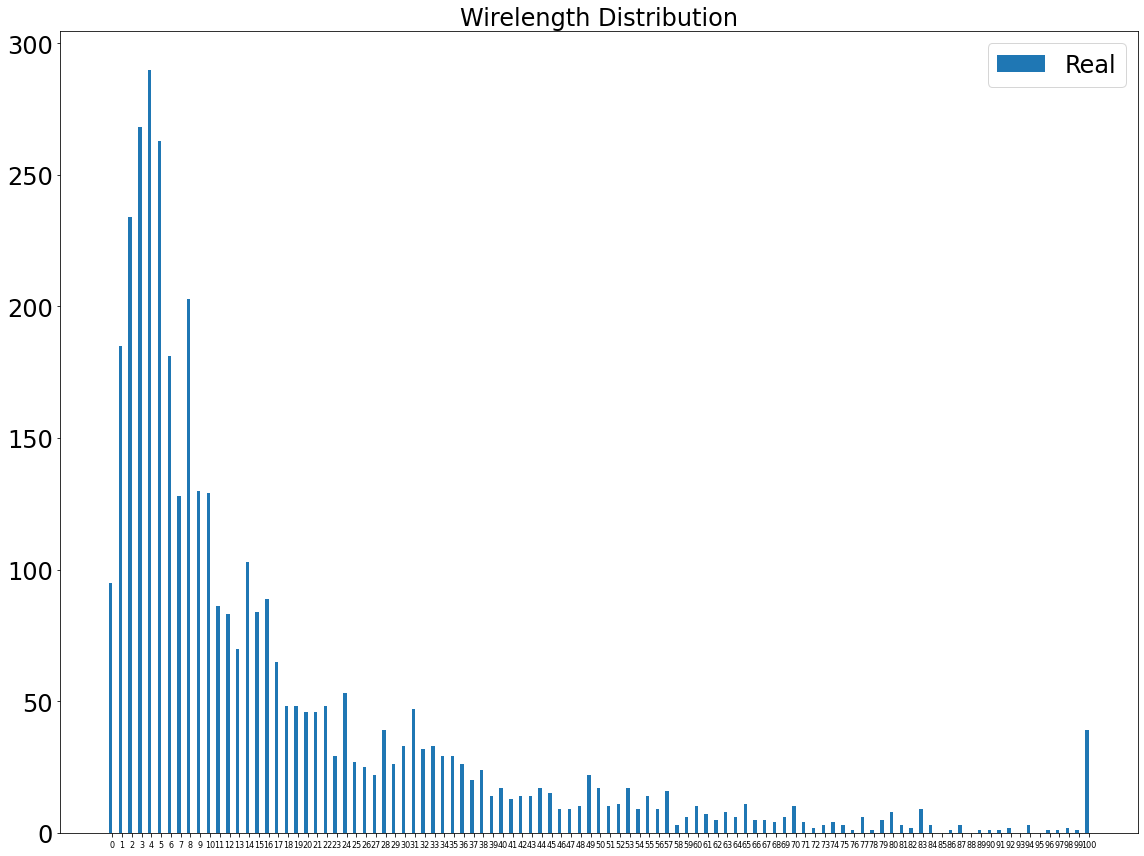

Num device: 4500
L min:1209600.0
L max:3048860000.0
Interval: 20889803.52


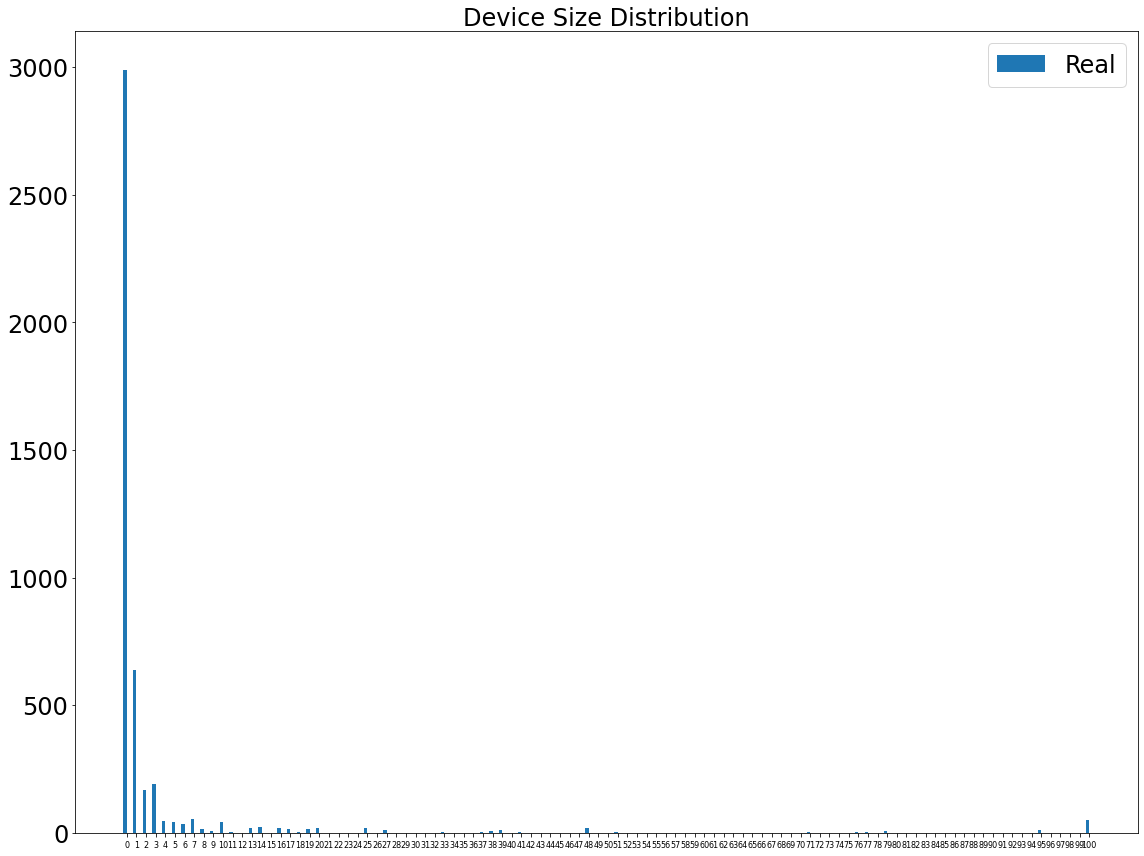

ALIGN(258)


In [4]:
%run ./Dataset_Generation_Skip_Large_Device_Size_Case.ipynb
#import import_ipynb
#import Dataset_Generation.ipynb
dataset = ALIGN(root='data_Skip_Large_Device_Case')

In [5]:
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset


train_dataset = dataset[0:233]
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = dataset[233:]
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(train_dataset)

ALIGN(233)


In [6]:
for i, data in enumerate(train_loader):
    print(i)
    print(data)
    print(data.edge_index_dict[('device', 'gate2net', 'net')])
    print(data.edge_index_dict[('net', 'net2gate', 'device')])
    break

0
HeteroDataBatch(
  device={
    x=[48, 5],
    batch=[48],
    ptr=[5]
  },
  net={
    y=[44],
    train_mask=[44],
    smallnet_mask=[44],
    largenet_mask=[44],
    x=[44, 5],
    batch=[44],
    ptr=[5]
  },
  (device, gate2net, net)={ edge_index=[2, 30] },
  (net, net2gate, device)={ edge_index=[2, 30] },
  (device, source2net, net)={ edge_index=[2, 77] },
  (net, net2source, device)={ edge_index=[2, 77] },
  (device, cap2net, net)={ edge_index=[2, 12] },
  (net, net2cap, device)={ edge_index=[2, 12] },
  (device, res2net, net)={ edge_index=[2, 18] },
  (net, net2res, device)={ edge_index=[2, 18] },
  (net, net2net, net)={ edge_index=[2, 24] }
)
tensor([[ 0,  2,  1,  3,  7, 10, 11, 13, 12, 14, 44, 45, 33, 28, 32, 39, 24, 26,
         40, 46, 41, 25, 16, 27, 21, 22, 34, 19, 19, 45],
        [ 1,  1,  2,  2, 10, 11, 14, 14, 15, 15, 18, 19, 21, 21, 21, 21, 21, 22,
         23, 25, 25, 26, 29, 32, 35, 36, 37, 38, 41, 42]])
tensor([[ 1,  1,  2,  2, 10, 11, 14, 14, 15, 15, 18, 19, 21

In [7]:
class Hetero_Model (torch.nn.Module):
    
    def __init__(self, heads=2, hidden_channel=32):
        super().__init__()
        
        self.fc1_device = Linear(in_channels=5, out_channels=hidden_channel)
        self.fc1_net    = Linear(in_channels=5, out_channels=hidden_channel)
        
        self.hetero_conv1 = HeteroConv({
                    ('device', 'gate2net', 'net'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'source2net', 'net'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'cap2net', 'net'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'res2net', 'net'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2gate', 'device'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2source', 'device'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2cap', 'device'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2res', 'device'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2net', 'net'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5)
                    }, aggr='sum')
        self.bnm1_device         = BatchNorm(hidden_channel*2)
        self.bnm1_net            = BatchNorm(hidden_channel*2)
        
        self.hetero_conv2 = HeteroConv({
                    ('device', 'gate2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'source2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'cap2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'res2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2gate', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2source', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2cap', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2res', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5)
                    }, aggr='sum')
        self.bnm2_device         = BatchNorm(hidden_channel*2)
        self.bnm2_net            = BatchNorm(hidden_channel*2)
            
        self.hetero_conv3 = HeteroConv({
                    ('device', 'gate2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'source2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'cap2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'res2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2gate', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2source', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2cap', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2res', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5)
                    }, aggr='sum')
        self.bnm3_device         = BatchNorm(hidden_channel*2)
        self.bnm3_net            = BatchNorm(hidden_channel*2)
        
        self.fc1  = Linear(hidden_channel*2*3, hidden_channel)
        self.bnm4 = BatchNorm(hidden_channel)
        self.fc2  = Linear(hidden_channel, 1)
        
    
    def forward(self, x_dict, edge_index_dict):
        
        x_dict['device'] = self.fc1_device(x_dict['device'])
        x_dict['net']    = self.fc1_net(x_dict['net'])
        

        x_dict           = self.hetero_conv1(x_dict, edge_index_dict)
        x_dict['device'] = self.bnm1_device(x_dict['device'])
        x_dict['net']    = self.bnm1_net(x_dict['net'])
        x_dict['device'] = F.elu(x_dict['device'])
        x_dict['net']    = F.elu(x_dict['net'])
        h1               = F.elu(x_dict['net'])
        
      
        x_dict           = self.hetero_conv2(x_dict, edge_index_dict)
        x_dict['device'] = self.bnm2_device(x_dict['device'])
        x_dict['net']    = self.bnm2_net(x_dict['net'])
        x_dict['device'] = F.elu(x_dict['device'])
        x_dict['net']    = F.elu(x_dict['net'])
        h2               = F.elu(x_dict['net'])
        
                
        x_dict           = self.hetero_conv3(x_dict, edge_index_dict)
        x_dict['device'] = self.bnm3_device(x_dict['device'])
        x_dict['net']    = self.bnm3_net(x_dict['net'])
        x_dict['device'] = F.elu(x_dict['device'])
        x_dict['net']    = F.elu(x_dict['net'])
        h3               = F.elu(x_dict['net'])
        
        x = torch.cat((h1, h2, h3), dim=1) 
        
        x = self.fc1(x)
        x = F.elu(x)
        x = F.dropout(x, 0.5, self.training)
        x = self.fc2(x)
        x = F.elu(x)
        
        return x

In [8]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)
model = Hetero_Model().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.7)
criterion = nn.MSELoss()


cuda:1


In [9]:
#model.to(device)
#model.load_state_dict(torch.load('./HAT_Small_Case.pth')['model_state_dict'])
#optimizer.load_state_dict(torch.load('./HAT_Small_Case.pth')['optimizer_state_dict'])

#print(device)


In [13]:
model.train()
Model_Path = './HAT_Small_Case.pth'

i = 0
for epoch in range(500):
    model.train()
        
    for data in train_loader:
        
        optimizer.zero_grad()  
        data.to(device)
        out = model(data.x_dict, data.edge_index_dict).squeeze()
        
        loss = criterion(out[data.smallnet_mask_dict['net']], data.y_dict['net'][data.smallnet_mask_dict['net']])
        loss.backward()
        optimizer.step()
        
        #data.to('cpu')
        #torch.cuda.empty_cache()
    
    scheduler.step()
    if epoch%10 == 0:
        print(f'[{epoch + 1}] loss: {loss:.5f}')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, Model_Path)
    if epoch%100 == 0:
        print(f'[{epoch + 1}] lr: {optimizer.param_groups[0]["lr"]}')
    
    

[1] loss: 35359724.00000
[1] lr: 0.0001412376244999999
[11] loss: 48332656.00000
[21] loss: nan
[31] loss: 30620090.00000
[41] loss: 9244162.00000
[51] loss: 15200306.00000
[61] loss: 21340526.00000
[71] loss: 57893316.00000
[81] loss: 21127898.00000
[91] loss: 17710832.00000
[101] loss: 30941374.00000
[101] lr: 9.886633714999992e-05
[111] loss: 23166496.00000
[121] loss: 16256447.00000
[131] loss: 9016228.00000
[141] loss: 38905132.00000
[151] loss: 32433834.00000
[161] loss: 54273008.00000
[171] loss: 24323894.00000
[181] loss: 3705797.00000
[191] loss: 4583881.00000
[201] loss: 20628240.00000
[201] lr: 6.920643600499994e-05
[211] loss: 13988601.00000
[221] loss: 27751756.00000
[231] loss: 31137752.00000
[241] loss: 16281640.00000
[251] loss: 7014786.50000
[261] loss: 20593910.00000
[271] loss: 51760332.00000
[281] loss: 8951027.00000
[291] loss: nan
[301] loss: 11342077.00000
[301] lr: 4.844450520349996e-05
[311] loss: 29725372.00000
[321] loss: 18441716.00000
[331] loss: 21507388.0

In [11]:
Model_Path = './HAT_Small_Case.pth'
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, Model_Path)

In [12]:
model.load_state_dict(torch.load('./HAT_Small_Case.pth')['model_state_dict'])
optimizer.load_state_dict(torch.load('./HAT_Small_Case.pth')['optimizer_state_dict'])

#model.load_state_dict(torch.load('../Impact_of_Resistor_Capacitor/HAT_Symmetric_Cap_Res.pth')['model_state_dict'])
#optimizer.load_state_dict(torch.load('../Impact_of_Resistor_Capacitor/HAT_Symmetric_Cap_Res.pth')['optimizer_state_dict'])

In [16]:
model.eval()
test_acc_list = []
out_list = []
ans_list = []
model.to('cpu')

for data in test_loader:
    
    #print(data.x_dict)
    out = model(data.x_dict, data.edge_index_dict).squeeze()
    loss = criterion(out[data.train_mask_dict['net']], data.y_dict['net'][data.train_mask_dict['net']])
    print(loss)
    
    #out = torch.exp(out[data.train_mask_dict['net']]).detach().numpy()
    out = out[data.train_mask_dict['net']].detach().numpy()
    #print(out)
    
    #ans = torch.exp(data.y_dict['net'][data.train_mask_dict['net']]).detach().numpy()
    ans = data.y_dict['net'][data.train_mask_dict['net']].detach().numpy()
    #print(ans)
    
    mape = np.multiply(np.mean(np.divide(np.absolute(np.subtract(ans, out)), ans)), 100)
    mse = np.mean(np.absolute(np.subtract(ans, out)))
    print("MAPE: " + str(mape) + "%")
    print("MSE: " + str(mse))
    print()
    

    for i in range(out.shape[0]):
        if(ans[i] >= 0):
            out_list.append(out[i])
            ans_list.append(ans[i])
    
        
#print(out_list)
#print(ans_list)

print(len(out_list))
print(len(ans_list))

out_list = np.array(out_list)
ans_list = np.array(ans_list) 
overall_mape = np.multiply(np.mean(np.divide(np.absolute(np.subtract(ans_list, out_list)), ans_list)), 100)
overall_mse = np.mean(np.absolute(np.subtract(ans_list, out_list)))
print("Overall MAPE: " + str(overall_mape) + "%")
print("Overall MSE: " + str(overall_mse))

tensor(7226250.5000, grad_fn=<MseLossBackward0>)
MAPE: 36.695483326911926%
MSE: 2244.5742

tensor(5442063.5000, grad_fn=<MseLossBackward0>)
MAPE: 36.276838183403015%
MSE: 1967.976

tensor(2.2905e+09, grad_fn=<MseLossBackward0>)
MAPE: 88.3415937423706%
MSE: 36559.195

tensor(5.6674e+08, grad_fn=<MseLossBackward0>)
MAPE: 68.39977502822876%
MSE: 17944.068

tensor(4.8631e+09, grad_fn=<MseLossBackward0>)
MAPE: 73.00763130187988%
MSE: 57974.74

tensor(27949782., grad_fn=<MseLossBackward0>)
MAPE: 30.122321844100952%
MSE: 3951.7825

tensor(5.8419e+08, grad_fn=<MseLossBackward0>)
MAPE: 106.4285159111023%
MSE: 18050.924

tensor(1.8929e+08, grad_fn=<MseLossBackward0>)
MAPE: 78.71781587600708%
MSE: 7193.048

tensor(2.3791e+09, grad_fn=<MseLossBackward0>)
MAPE: 77.53938436508179%
MSE: 39828.992

tensor(3.8181e+08, grad_fn=<MseLossBackward0>)
MAPE: 36.40117943286896%
MSE: 11379.428

tensor(7.7741e+08, grad_fn=<MseLossBackward0>)
MAPE: 58.92935395240784%
MSE: 22962.12

tensor(1.9416e+08, grad_fn=<Mse

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize = (12, 12))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

ax.scatter(out_list, ans_list, alpha=0.7)
#ax.set_xlim(0,300000)
#ax.set_ylim(0,300000)

m, b = np.polyfit(out_list, ans_list, 1)
plt.plot(out_list, m*out_list + b, 'r')

plt.show()

In [ ]:
N = 20

num_wire = len(out_list)
ans_sorted = np.sort(ans_list)
#out_sorted = np.sort(out_list) 
print("Num wire: " + str(num_wire))
    
L_min = ans_sorted[0]
L_max = ans_sorted[(num_wire-1) - int(0.05*num_wire)]
print("L min:" + str(L_min))
print("L max:" + str(L_max))
    
ans_label = np.zeros(num_wire)
out_label = np.zeros(num_wire)
interval = (L_max-L_min) / N
print("Interval: " + str(interval))
    
       
for i in range(N+1):
    interval_min = L_min + (i*interval)
    interval_max = L_min + ((i+1)*interval)
        
    if (i == N):
        ans_label = np.where((ans_list >= interval_min), i, ans_label)
        out_label = np.where((out_list >= interval_min), i, out_label)
    else:
        ans_label = np.where((ans_list >= interval_min) & (ans_list < interval_max), i, ans_label)
        out_label = np.where((out_list >= interval_min) & (out_list < interval_max), i, out_label)
            
#print(out_label)
#print(ans_label)
 
avg_value = np.zeros(N+1)
bin_num = np.zeros(N+1)
pred_avg_value = np.zeros(N+1)
pred_bin_num = np.zeros(N+1)
    
print("correlation: ")
    
for i in range(N+1):
    
    ans_mask = np.where(ans_label == i, True, False)
    bin_num[i] = len(ans_list[ans_mask])
    avg_value[i] = np.mean(ans_list[ans_mask])
        
    pred_mask = np.where(out_label == i, True, False)
    pred_bin_num[i] = len(out_list[pred_mask])
    pred_avg_value[i] = np.mean(out_list[pred_mask])

print(bin_num)
print(pred_bin_num)
    
#print(avg_value)
#print(pred_avg_value)
    
#print(np.corrcoef(avg_value, pred_avg_value))
      
    
print("MAPE:")
    
mape = np.multiply(np.divide(np.absolute(np.subtract(ans_list, out_list)), ans_list), 100)
   
mape_list = []
for i in range(N+1):
    out_mask = np.where(out_label == i, True, False)
    mape_list.append(np.mean(mape[out_mask]))
        
#print(mape)
print(mape.mean())
print(mape_list)
    
    
print("====================================")
#break

In [ ]:
import matplotlib.pyplot as plt
labels = [i for i in range(N+1)]

x = np.arange(N+1)  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, bin_num, width, label='Real')
rects2 = ax.bar(x + width/2, pred_bin_num, width, label='Pred')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('num', fontsize=24)
ax.set_title('Wirelength Distribution', fontsize=24)
plt.yticks(fontsize=24)
ax.set_xticks(x, labels, fontsize=24)
ax.legend(loc='best', fontsize=24)


fig.set_size_inches(16, 12)
fig.tight_layout()

plt.show()


In [ ]:
labels = [i for i in range(20)]



x = np.arange(20)  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mape_list, width, label='MAPE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('%', fontsize=24)
ax.set_title('MAPE', fontsize=24)
plt.yticks(fontsize=24)
ax.set_xticks(x, labels, fontsize=24)
ax.legend(loc='best', fontsize=24)


fig.set_size_inches(16, 12)
fig.tight_layout()

plt.show()